# Plots for mutation-transmissibility paper

This notebook generates plots for the paper/ directory. This assumes you've alread run
```sh
python rank_mutations --full --num-features=0  # ~5 minutes on GPU
```

In [1]:
import re
import math
import pickle
import logging
from collections import Counter, OrderedDict
import matplotlib
import matplotlib.pyplot as plt
import torch
import pyro
import pyro.distributions as dist
from pyro import poutine
from pyrocov.geo import gisaid_to_jhu_location, parse_date, pd_to_torch, read_csv
from pyrocov import mutrans, pangolin

matplotlib.rcParams['figure.dpi'] = 200
logging.basicConfig(format="%(relativeCreated) 9d %(message)s", level=logging.INFO)

## Load data

In [2]:
%%time
dataset = mutrans.load_data()
print(dataset.keys())
locals().update(dataset)

     2647 Loading data
     3237 Training on 914312 rows with columns:
     3238 lineage, virus_name, accession_id, collection_date, location, add_location, day
     3294 Loaded torch.Size([1245, 13401]) feature matrix
    11954 WARNING skipping unsampled lineage B.1.1.29
    12203 Keeping 914311/914312 rows
    12216 Keeping 224/238 regions
    12322 Keeping 2219/13401 mutations


dict_keys(['location_id', 'mutations', 'weekly_strains', 'features', 'lineage_id', 'lineage_id_inv'])
CPU times: user 9.51 s, sys: 602 ms, total: 10.1 s
Wall time: 9.8 s


## Load trained models

In [3]:
fits = torch.load("results/mutrans.pt", map_location="cpu")
best_fit = list(fits.values())[-1]
for key in fits:
    print(key)

('map', 1001, 0.05, 0.1, None)
('normal', 2001, 0.05, 0.1, None)
('mvn', 10001, 0.01, 0.1, None)
('mvn_dependent', 10001, 0.01, 0.1, None)


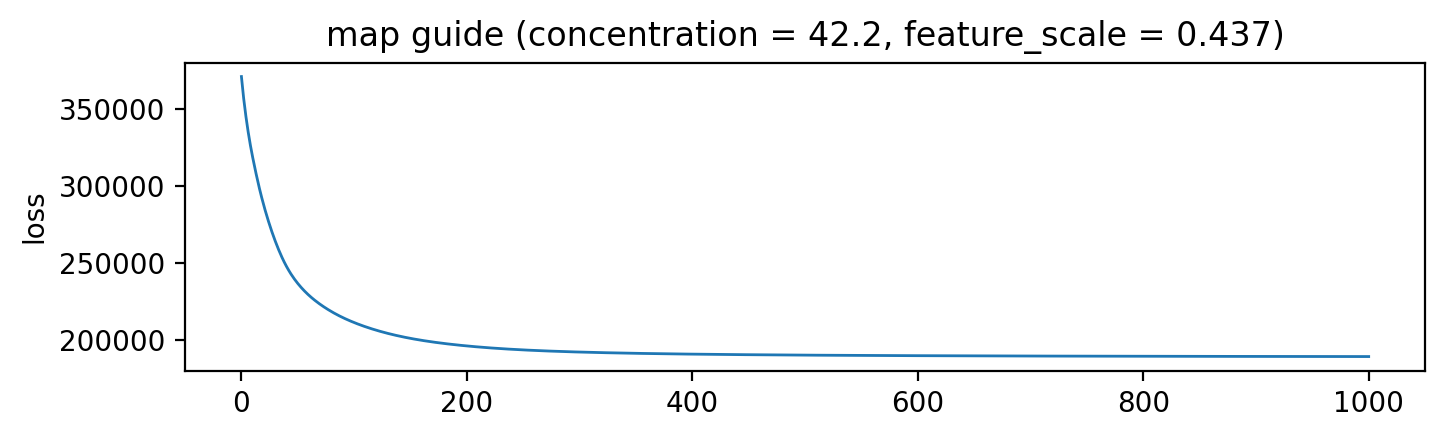

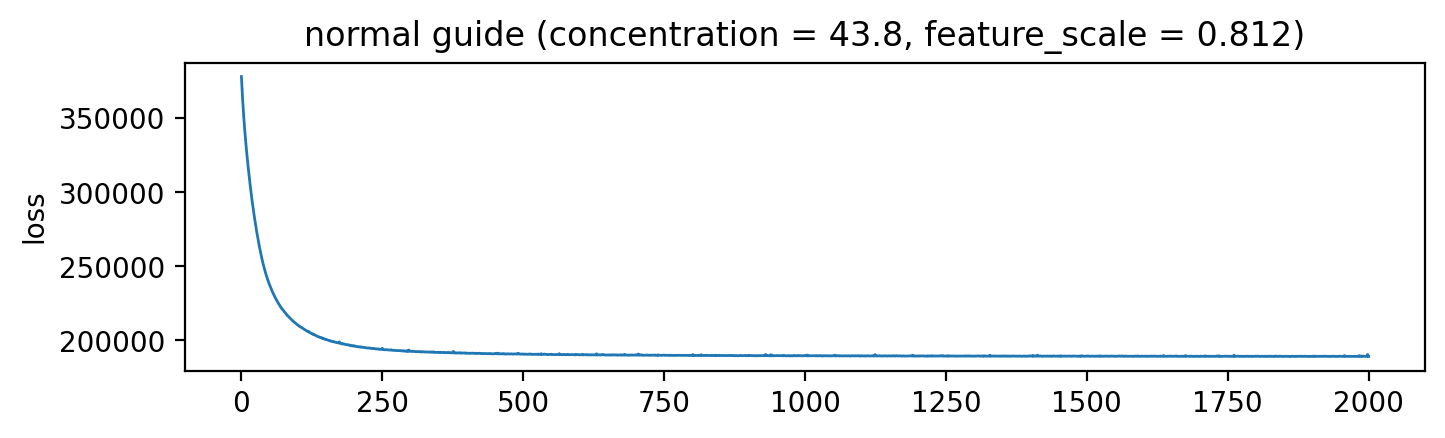

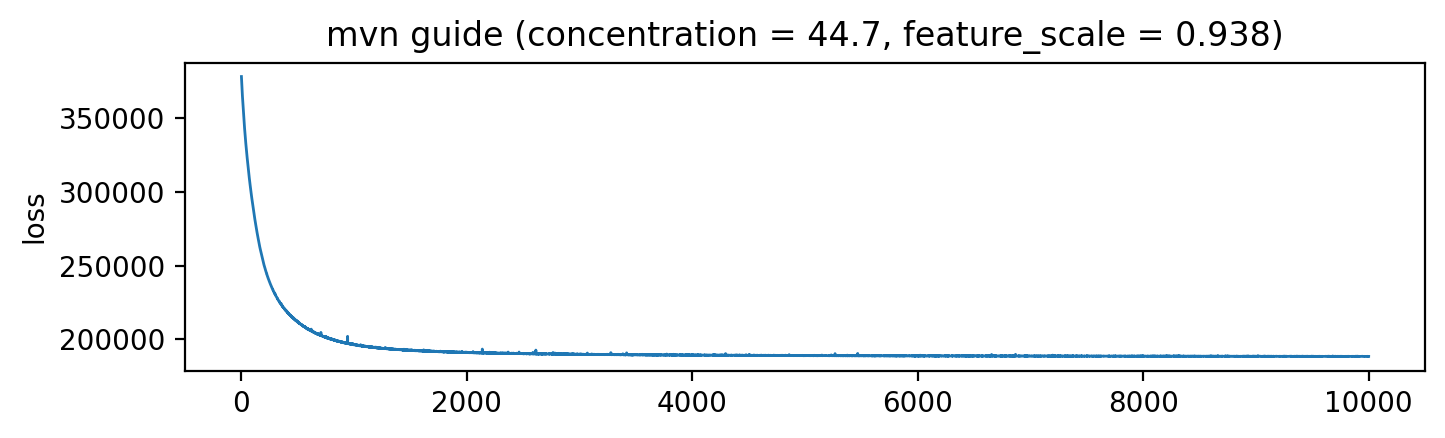

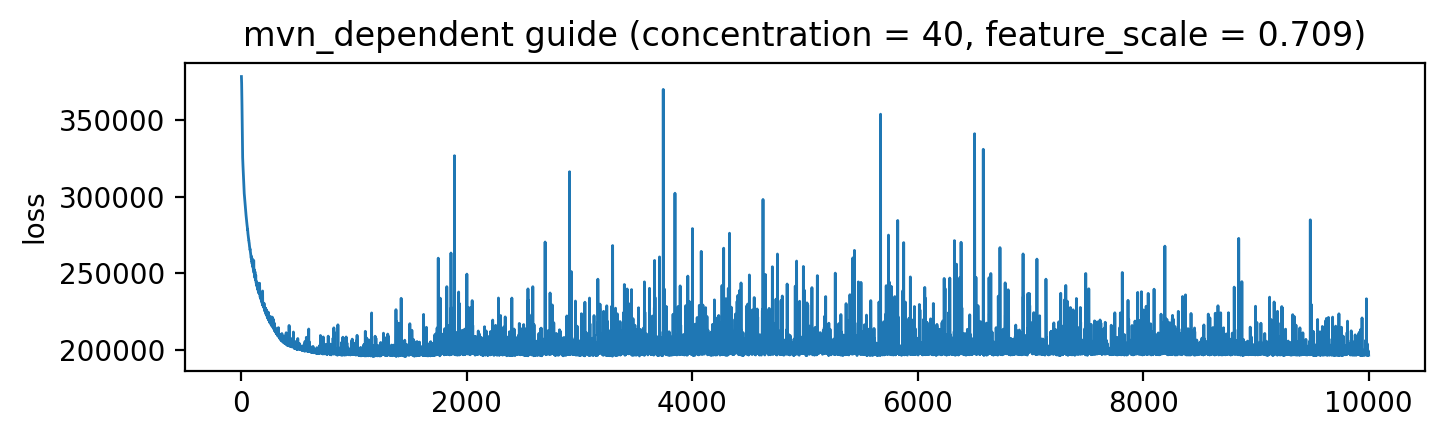

In [4]:
for key, value in fits.items():
    plt.figure(figsize=(8, 2))
    plt.plot(value["losses"], lw=1)
    # plt.xlabel("SVI step")
    plt.ylabel("loss")
    plt.title("{} guide (concentration = {:0.3g}, feature_scale = {:0.3g})".format(
        key[0],
        value["median"]["concentration"],
        value["median"]["feature_scale"]));

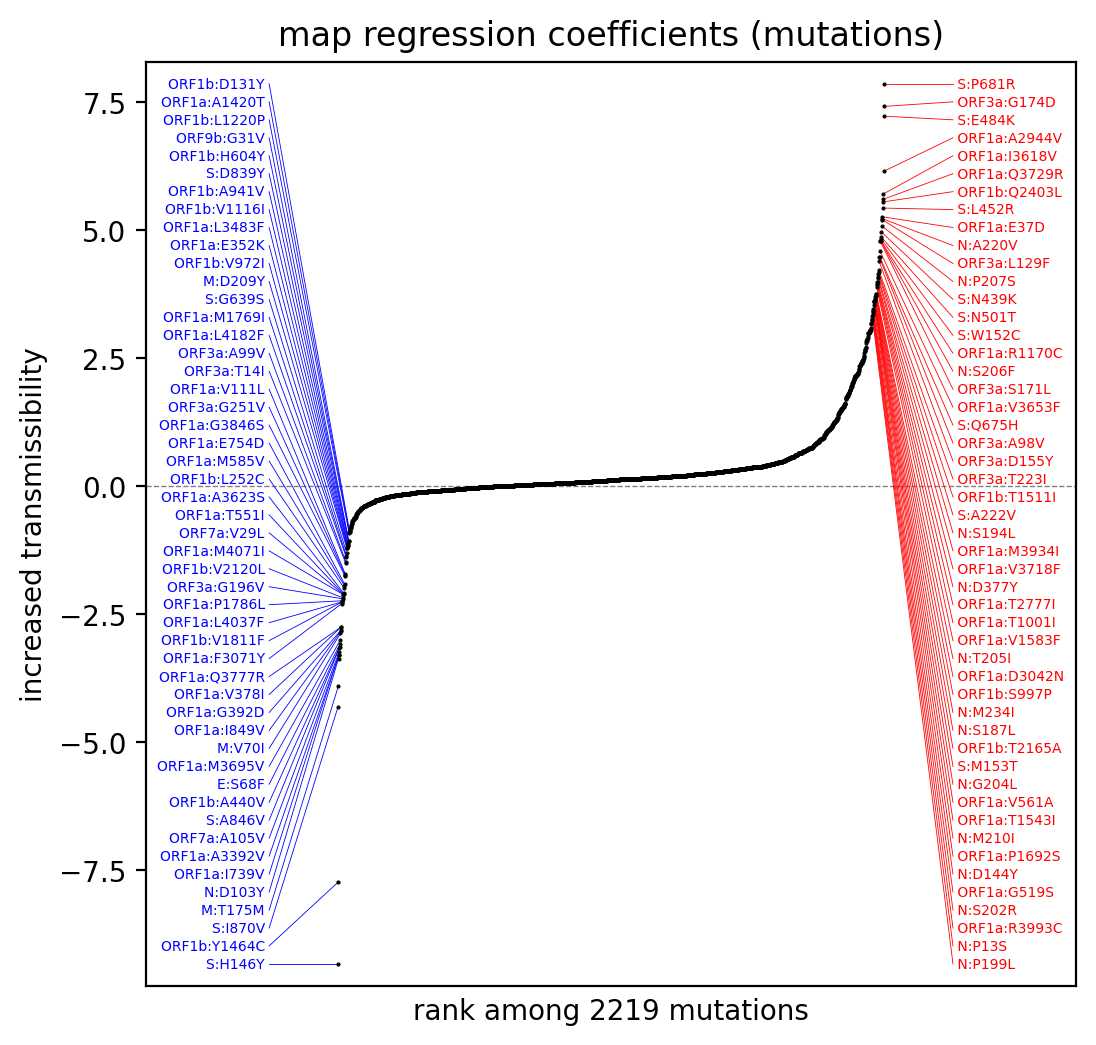

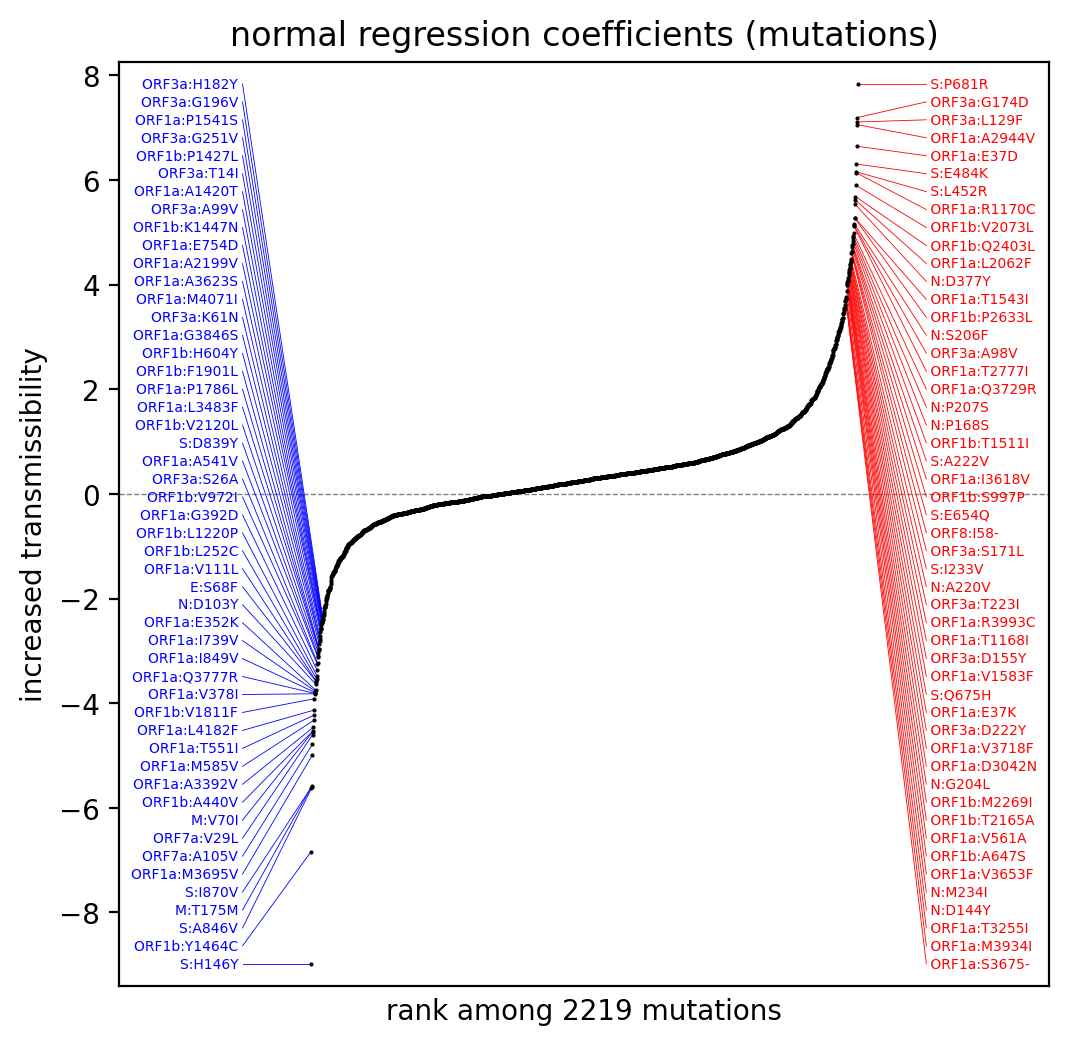

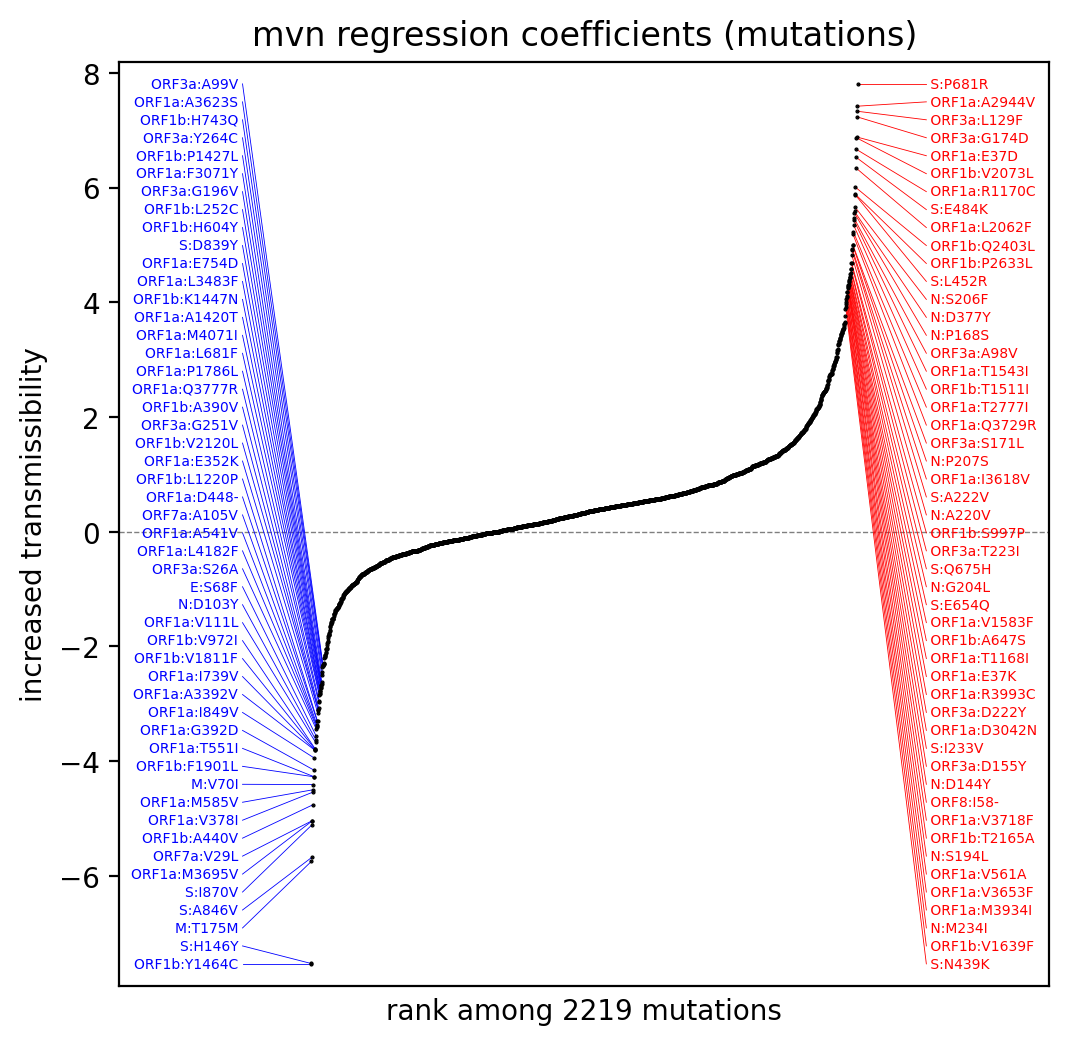

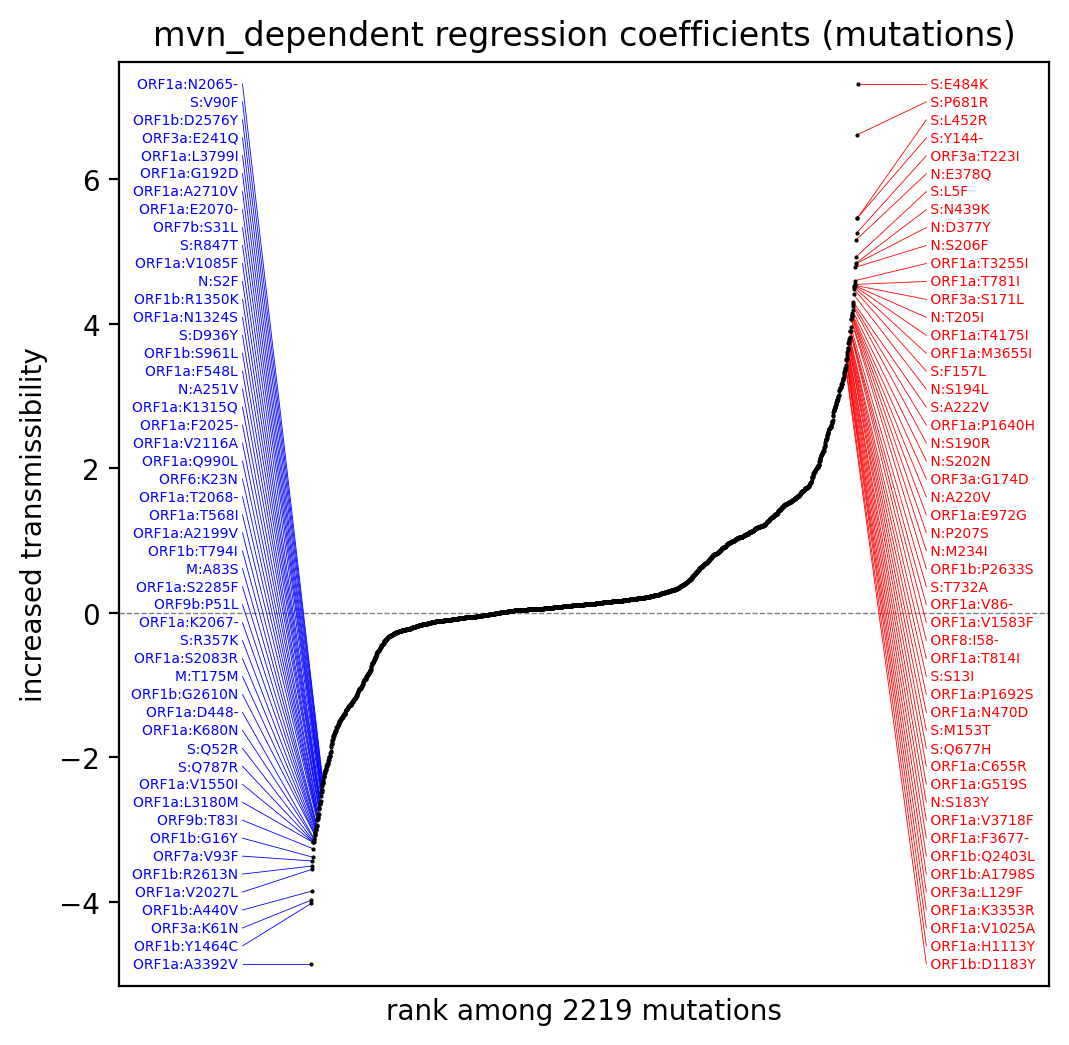

In [5]:
def plot_coefficients(name, rate_coef):
    xs, idx = rate_coef.sort(0)
    assert len(idx) == len(mutations)
    plt.figure(figsize=(6, 6))
    plt.title(f"{name} regression coefficients (mutations)")
    plt.plot(xs, 'k.', lw=0, markersize=1, zorder=10)
    plt.axhline(0, color='black', lw=0.5, linestyle='--', alpha=0.5)
    plt.xlabel(f"rank among {len(xs)} mutations")
    plt.ylabel("increased transmissibility")

    I = len(idx)
    y0 = float(xs.min())
    y1 = float(xs.max())
    N = 50
    for i in range(N):
        x = -I / 8
        y = y0 + (y1 - y0) * i / (N - 1)
        plt.plot([i, x], [xs[i], y], color='blue', lw=0.3)
        plt.text(x, y, mutations[int(idx[i])] + " ", fontsize=5, color='blue',
                 verticalalignment="center", horizontalalignment="right")
    for i in range(I - N, I):
        x = I + I / 8
        y = y1 + (y0 - y1) * (I - i - 1) / (N - 1)
        plt.plot([i, x], [xs[i], y], color='red', lw=0.3)
        plt.text(x, y, " " + mutations[int(idx[i])], fontsize=5, color='red',
                 verticalalignment="center", horizontalalignment="left")
    plt.ylim(y0 - (y1 - y0) / 40, y1 + (y1 - y0) / 40)
    plt.xlim(-0.35 * I, 1.35 * I)
    plt.xticks(())

for key, value in fits.items():
    plot_coefficients(key[0], value["median"]["rate_coef"])

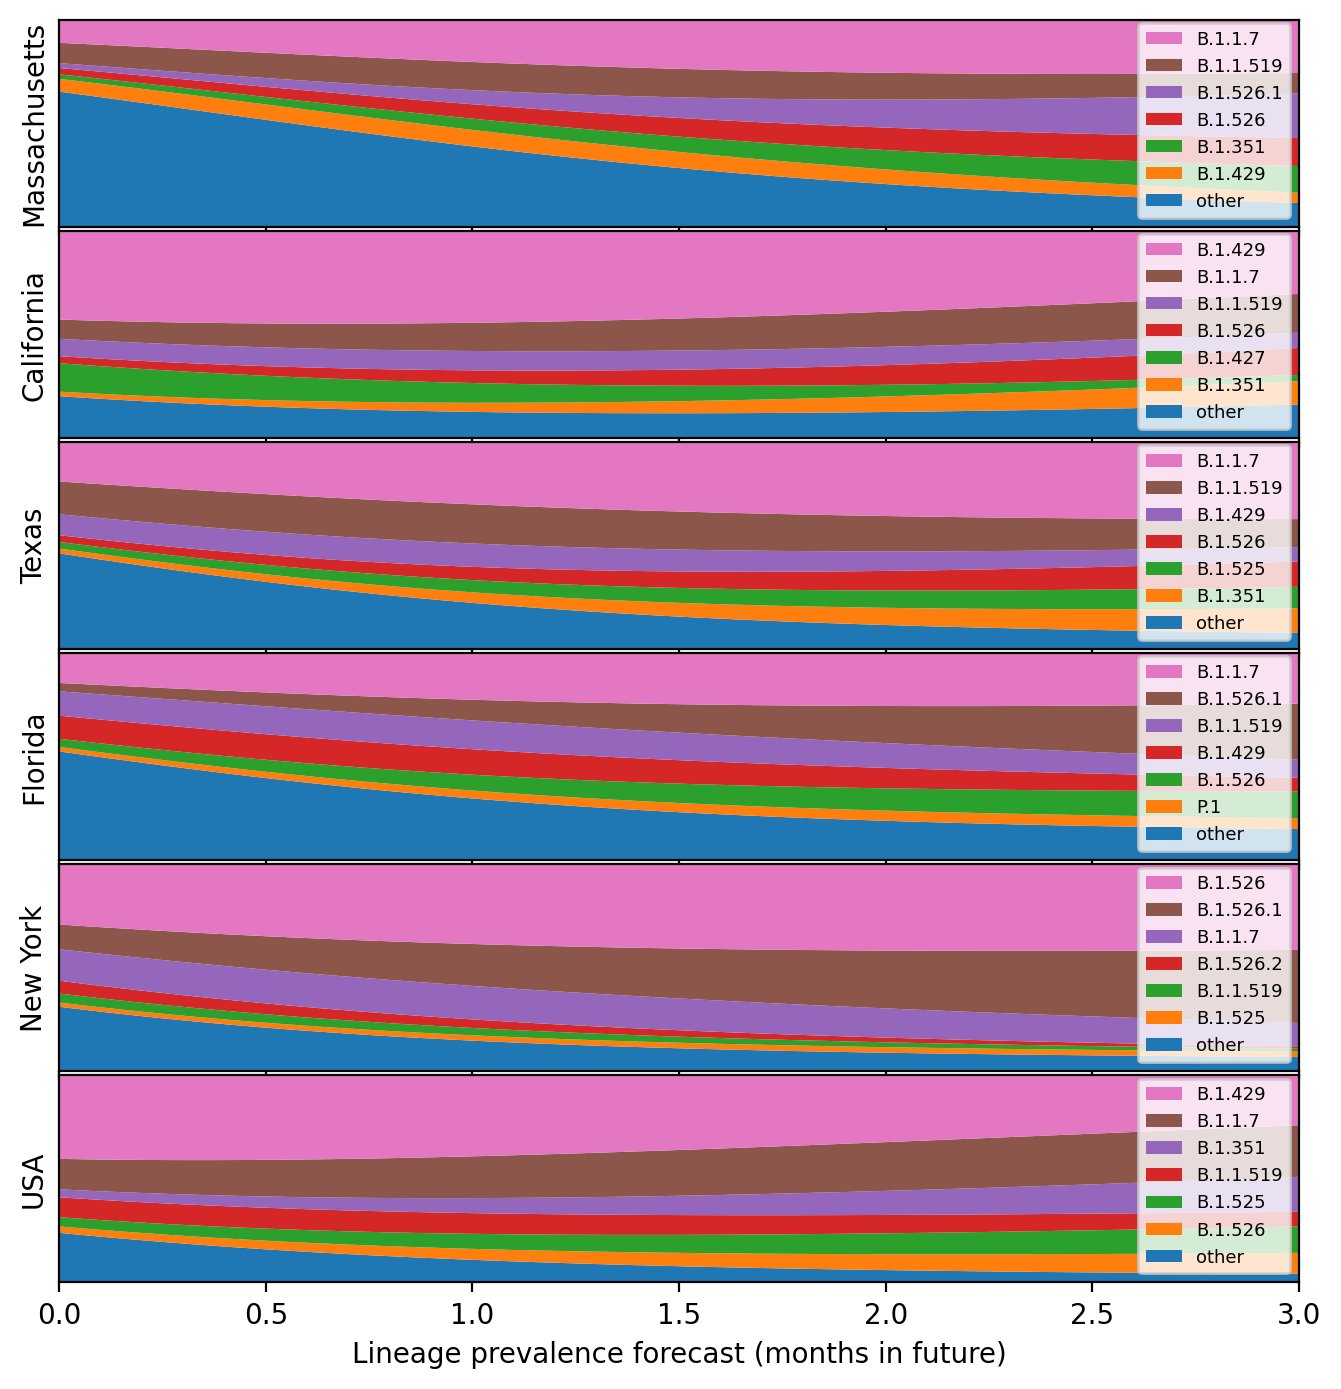

In [6]:
def plot_decomposition(median, queries, num_parts=7, months_ahead=3):
    if isinstance(queries, str):
        queries = [queries]
    fig, axes = plt.subplots(len(queries), figsize=(8, 1 + 1.2 * len(queries)), sharex=True)
    for row, (place_query, ax) in enumerate(zip(queries, axes)):
        names = [name for name, i in location_id.items() if place_query in name]
        ids = [location_id[name] for name in names]
        assert ids, "no locations matching " + place_query
        rate = median["rate"]
        # FIXME this ignores region population when aggregating:
        init = median["init"][ids].logsumexp(0)
        assert init.shape == rate.shape
        time = torch.linspace(0, months_ahead / 12.0, 100)
        portion = (init + rate * time[:, None]).softmax(-1)

        # Aggregate into top + others.
        best = portion.sum(0).sort(0, descending=True).indices
        parts = {"other": None}
        for i in range(num_parts - 1):
            i = best[num_parts - i - 2].item()
            parts[lineage_id_inv[i]] = portion[:, i].clone()
            portion[:, i] = 0
        parts["other"] = portion.sum(-1)
        months = time * 12

        ax.stackplot(months, *parts.values(), labels=tuple(parts))
        ax.set_xlim(months.min(), months.max())
        ax.set_ylim(0, 1)
        ax.set_yticks(())
        ax.set_ylabel(names[0].split("/")[-1].strip() if len(names) == 1 else place_query)
        if row == len(axes) - 1:
            ax.set_xlabel("Lineage prevalence forecast (months in future)")
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles[::-1], labels[::-1], loc="lower right", prop={"size": 6.5})
    plt.subplots_adjust(hspace=0.02);

plot_decomposition(best_fit["median"],
                   ["Mass", "Calif", "Texas", "Florida", "New York", "USA"])

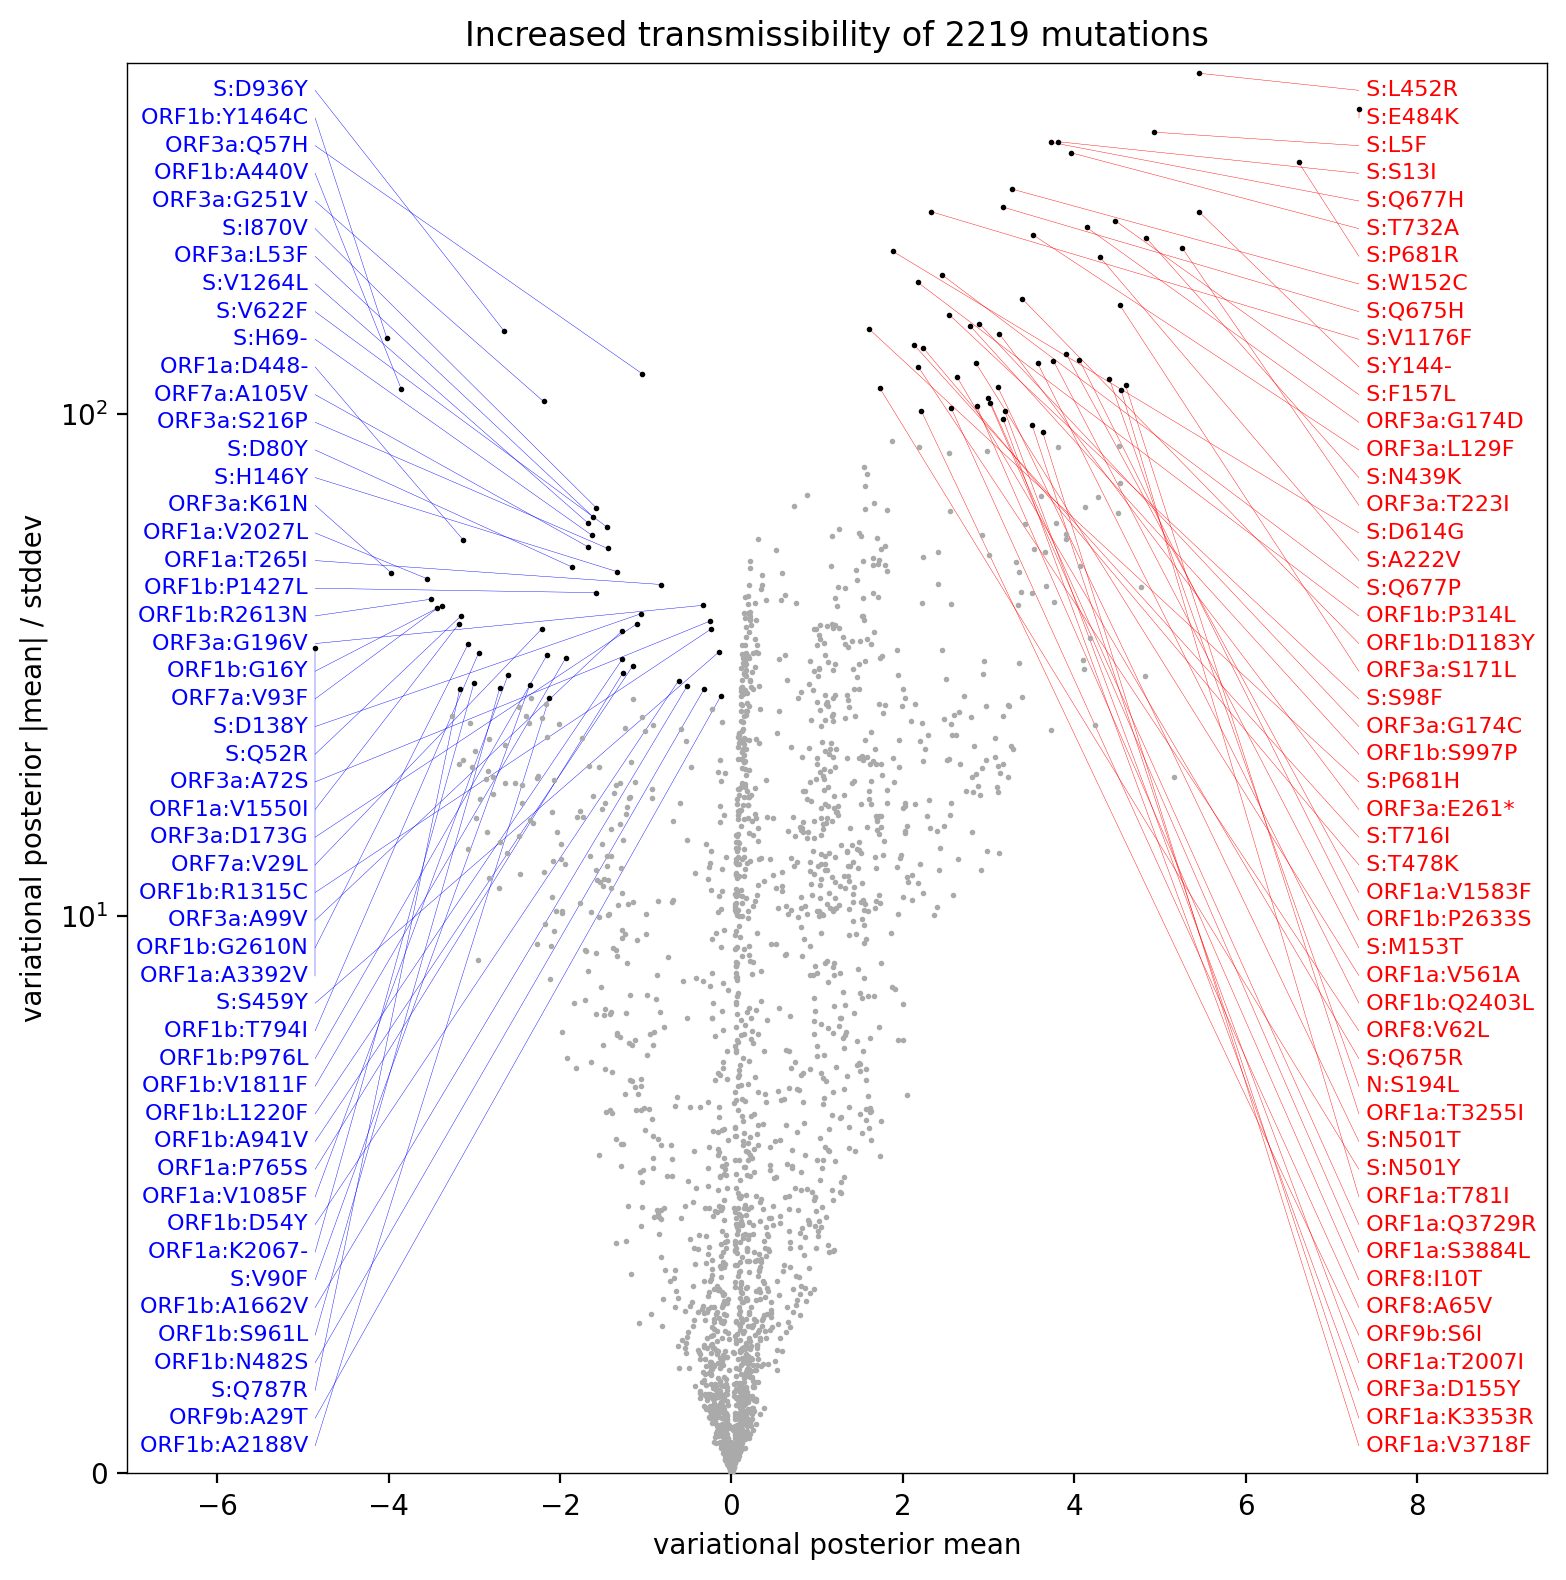

In [7]:
def plot_volcano(mean, std, filenames=()):
    xs = mean
    ys = mean.abs() / std
    assert len(xs) == len(mutations)
    y0, y1 = float(ys.min()), float(ys.max())
    x0, x1 = float(xs.min()), float(xs.max())
    ys, idx = ys.sort(0, descending=True)
    xs = xs[idx]
    pos = (0 < xs) & (xs < math.inf)
    neg = (-math.inf < xs) & (xs < 0)
    ys_pos, ys_neg = ys[pos], ys[neg]
    xs_pos, xs_neg = xs[pos], xs[neg]
    idx_pos, idx_neg = idx[pos], idx[neg]
    N = 50

    plt.figure(figsize=(8, 8))
    plt.title(f"Increased transmissibility of {len(mutations)} mutations")
    for mask in [pos, neg]:
        xs_mask, ys_mask = xs[mask], ys[mask]
        plt.plot(xs_mask[:N], ys_mask[:N], 'k.', lw=0, markersize=2, zorder=10)
        plt.plot(xs_mask[N:], ys_mask[N:], 'k.', lw=0, markersize=2, zorder=10, color="#aaa")
    plt.xlabel("variational posterior mean")
    plt.ylabel("variational posterior |mean| / stddev")
    plt.xlim(x0 - (x1 - x0) * 0.18, x1 + (x1 - x0) * 0.18)
    plt.ylim(0, None)
    plt.yscale("symlog", linthresh=10)
    ax = plt.gca()
    for spine in ax.spines.values():
        spine.set_linewidth(0.5)
        
    t = (ax.transScale + ax.transLimits).inverted()
    for i in range(N):
        x = x0
        _, y = t.transform((0, 1 - (i + 1) / (N + 1)))
        plt.plot([x, xs_neg[i]], [y, ys_neg[i]], color='blue', lw=0.15)
        plt.text(x, y, mutations[int(idx_neg[i])] + " ", fontsize=8, color='blue',
                 verticalalignment="center", horizontalalignment="right")
    for i in range(N):
        x = x1
        _, y = t.transform((0, 1 - (i + 1) / (N + 1)))
        plt.plot([x, xs_pos[i]], [y, ys_pos[i]], color='red', lw=0.15)
        plt.text(x, y, " " + mutations[int(idx_pos[i])], fontsize=8, color='red',
                 verticalalignment="center", horizontalalignment="left")
    plt.tight_layout()
    for f in filenames:
        plt.savefig(f)

plot_volcano(best_fit["mean"], best_fit["std"],
             filenames=["paper/volcano.png", "paper/volcano.pdf"])

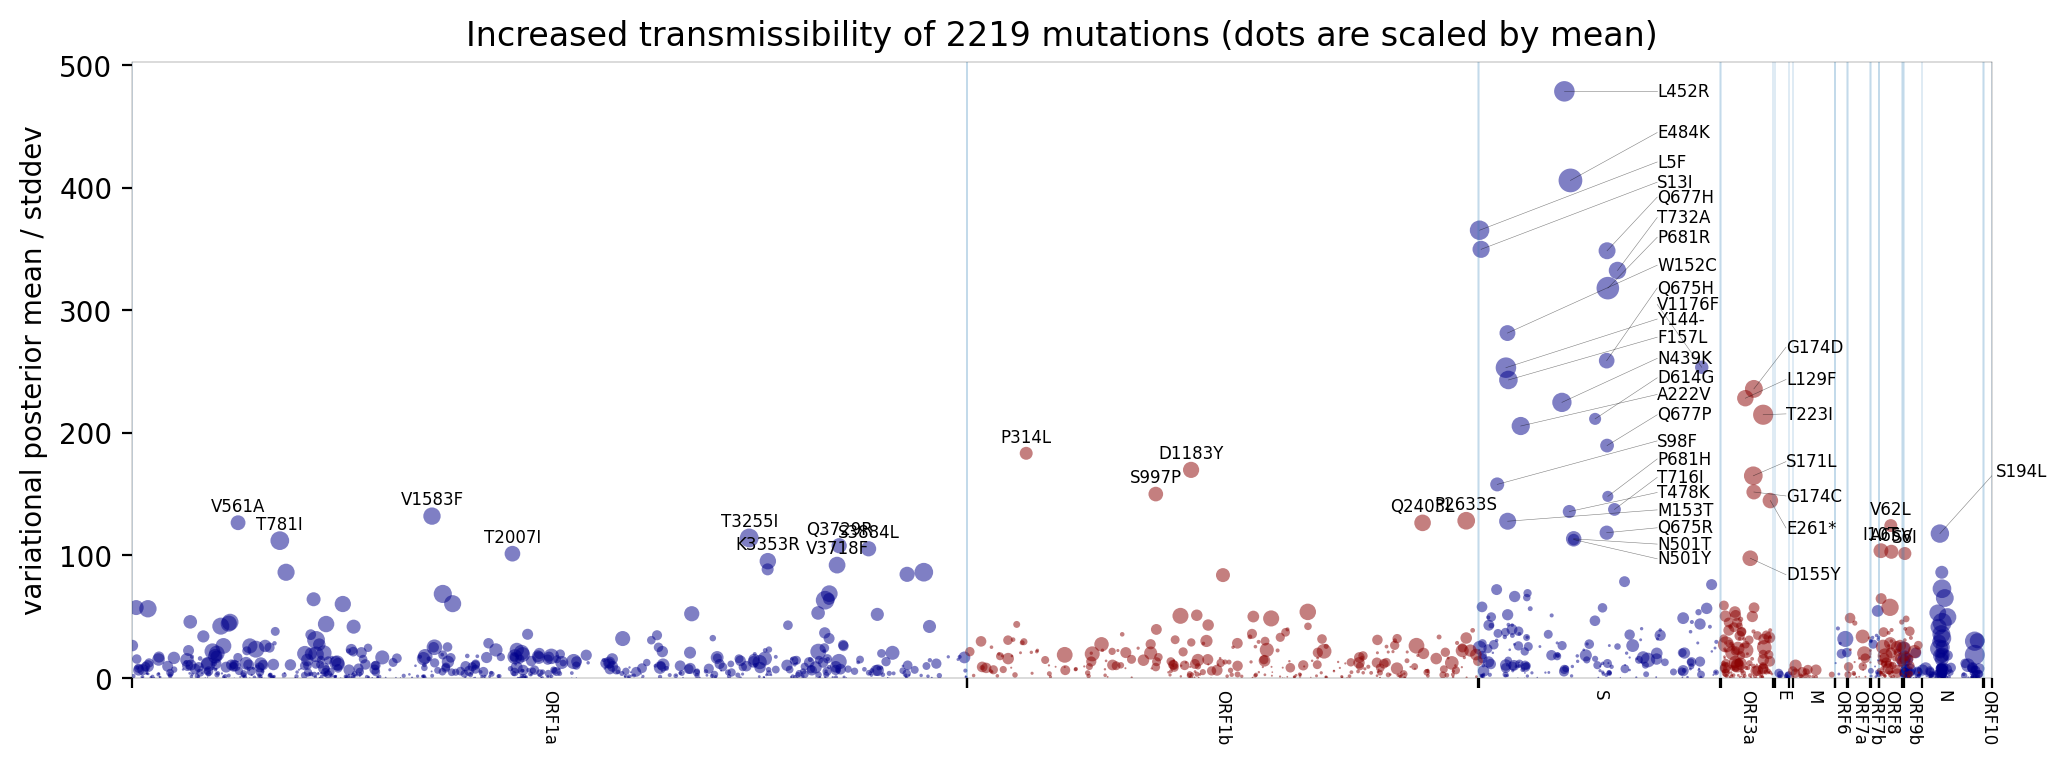

In [8]:
from pyrocov.sarscov2 import GENE_TO_POSITION, aa_mutation_to_position

def plot_manhattan(mean, std, top_k=50, filenames=()):
    sigma = mean / std.clamp(min=1e-8)
    y1 = sigma.max().item()
    position = torch.tensor([aa_mutation_to_position(m) for m in mutations])
    assert len(mean) == len(mutations)
    gene_id = {gene_name: i for i, gene_name in enumerate(GENE_TO_POSITION)}
    gene_ids = torch.tensor([gene_id[m.split(":")[0]] for m in mutations])
    even = (gene_ids % 2 == 0) & (mean > 0)
    odd = (gene_ids % 2 == 1) & (mean > 0)

    plt.figure(figsize=(12, 4))
    plt.title(f"Increased transmissibility of {len(mutations)} mutations"
              " (dots are scaled by mean)")
    for mask, color in zip([even, odd], ["darkblue", "darkred"]):
        plt.scatter(position[mask].numpy(), sigma[mask].numpy(), 10 * mean[mask].numpy(),
                    color=color, alpha=0.5, lw=0)
    special = {"S": [], "N": [], "ORF3a": []}  # Many hits, plot with lines
    for i in sigma.sort(0, descending=True).indices[:top_k].tolist():
        x = float(position[i])
        y = float(sigma[i])
        gene, name = mutations[i].split(":")
        if gene in special:
            special[gene].append((y, x, name))
            continue
        plt.text(x, y + y1/80, name, fontsize=6,
                 verticalalignment="bottom", horizontalalignment="center")
    for special_ in special.values():
        special_.sort(reverse=True)
    y_bounds = {k: (min(y for (y, _, _) in v), max(y for (y, _, _) in v))
                for k, v in special.items()}
    y_bounds = {k: (lb * 0.8, ub * 0.8 + y1 * 0.2) for k, (lb, ub) in y_bounds.items()}
    for i, (y, x, name) in enumerate(special["S"]):
        lb, ub = y_bounds["S"]
        y_label = 0.3 * y + 0.7 * (ub + (lb - ub) * (i / (len(special["S"]) - 0.99)))
        x_label = GENE_TO_POSITION["S"][1] - 1000
        plt.text(x_label, y_label, name, fontsize=6,
                 verticalalignment="center", horizontalalignment="left")
        plt.plot([x, x_label], [y, y_label], 'k-', lw=0.2, alpha=0.5)
    for gene in ["N", "ORF3a"]:
        for i, (y, x, name) in enumerate(special[gene]):
            lb, ub = y_bounds[gene]
            y_label = 0.3 * y + 0.7 * (ub + (lb - ub) * (i / (len(special[gene]) - 0.99)))
            x_label = GENE_TO_POSITION[gene][1] + 200
            plt.text(x_label, y_label, name, fontsize=6,
                     verticalalignment="center", horizontalalignment="left")
            plt.plot([x, x_label], [y, y_label], 'k-', lw=0.2, alpha=0.5)
        
    start_end = list(GENE_TO_POSITION.values())
    plt.xlim(start_end[0][0], start_end[-1][-1])
    xticks = []
    for i, (gene, (start, end)) in enumerate(GENE_TO_POSITION.items()):
        if gene == "ORF14":
            continue  # skip overlapping frame
        plt.axvline(start, lw=0.1)
        plt.axvline(end, lw=0.1)
        xticks.extend([start, end])
        plt.text((start + end) / 2, -y1 / 50, gene, rotation=-90,
                 fontsize=6, verticalalignment="top", horizontalalignment="center")
    plt.xticks(xticks, labels=())
    plt.ylim(0, None)
    ax = plt.gca()
    for spine in ax.spines.values():
        spine.set_linewidth(0.1)
    plt.ylabel("variational posterior mean / stddev")
    for f in filenames:
        plt.savefig(f)

plot_manhattan(best_fit["mean"], best_fit["std"],
               filenames=["paper/manhattan.png", "paper/manhattan.pdf"])

## Extracting a table of top mutations and their stories

In [9]:
parent_features = torch.zeros_like(features)
for c, child in enumerate(lineage_id_inv):
    child = pangolin.decompress(child)
    parent = child
    while True:
        parent = "A" if parent == "A" else pangolin.get_parent(parent)
        try:
            p = lineage_id[pangolin.compress(parent)]
            break
        except KeyError:
            continue
    parent_features[c] = features[p]

In [10]:
def find_emergences(i):
    delta = features[:, i] - parent_features[:, i]
    emerged = set((delta > 0.5).nonzero(as_tuple=True)[0].tolist())
    emerged.add(delta.argmax().item())
    result = []
    for k in sorted(emerged):
        name = lineage_id_inv[k]
        longname = pangolin.decompress(name)
        result.append(name if name == longname else f"{name} ({longname})")
    return result

In [11]:
def write_mutation_table(mean, std, filename="paper/top_mutations.md", top_k=200):
    sigma = mean / std.clamp(min=1e-8)
    lineage_counts = weekly_strains.sum((0, 1))
    with open(filename, "wt") as md, open(filename.replace(".md", ".tsv"), "wt") as tsv:
        md.write("This file was automatically generated by mutation_stochatic_model.ipynb\n")
        md.write("\n")
        md.write("| mutation | mean/stddev | mean | emerged in lineages |\n")
        md.write("| -------- | ----------- | ---- | ------------------- |\n")
        tsv.write("mutation\tmean/stddev\tmean\temerged in lineages\n")
        for i in sigma.sort(0, descending=True).indices[:top_k].tolist():
            emerged = find_emergences(i)
            md.write("| {} | {:0.3g} | {:0.3g} | {} |\n".format(
                mutations[i], sigma[i], mean[i], ", ".join(emerged)
            ))
            tsv.write("{}\t{:0.6g}\t{:0.6g}\t{}\n".format(
                mutations[i], sigma[i], mean[i], ", ".join(emerged)
            ))

write_mutation_table(best_fit["mean"], best_fit["std"])

In [12]:
def write_strain_table(mean, filename="paper/top_strains.md", top_k=1000):
    rate = mean.type_as(features) @ features.T * (12 / 365.25 * 14)
    num_samples = weekly_strains.sum(0).long()
    global_samples = num_samples.sum(0)
    us_samples = sum(num_samples[i] for name, i in location_id.items() if " USA " in name)
    ma_samples = sum(num_samples[i] for name, i in location_id.items() if " Mass" in name)
    lineages = [None] * len(lineage_id)
    for lineage, i in lineage_id.items():
        lineages[i] = lineage
    with open(filename, "wt") as md, open(filename.replace(".md", ".tsv"), "wt") as tsv:
        md.write("This file was automatically generated by mutation_stochatic_model.ipynb\n")
        md.write("\n")
        md.write("| strain | log growth rate | global samples | US samples | MA samples |\n")
        md.write("| ------ | --------------- | -------------- | ---------- | ---------- |\n")
        tsv.write("rank\tstrain\tlog growth rate\tnumber of samples\n")
        for i in rate.sort(0, descending=True).indices[:top_k].tolist():
            emerged = find_emergences(i)
            md.write("| {} | {:0.4g} | {:d} | {:d} | {:d}\n".format(
                lineages[i], rate[i], global_samples[i], us_samples[i], ma_samples[i]
            ))
            tsv.write("{}\t{:0.6g}\t{:d}\n".format(
                lineages[i], rate[i], global_samples[i], us_samples[i], ma_samples[i]
            ))

write_strain_table(best_fit["mean"])

## Fit on subsets of data

In [13]:
with open("results/gisaid.columns.pkl", "rb") as f:
    columns = pickle.load(f)

In [14]:
print(Counter([n for n in columns["virus_name"] if "-CDC-2-" in n]).most_common(2))
print(Counter([n for n in columns["location"] if "USA" in n]).most_common(2))
print(Counter([n for n in columns["location"] if "United King" in n]).most_common(2))

[('hCoV-19/USA/KS-CDC-2-3693594/2020', 1), ('hCoV-19/USA/KS-CDC-2-3693489/2020', 1)]
[('North America / USA / Texas / Houston', 25968), ('North America / USA / California', 10692)]
[('Europe / United Kingdom / England', 263176), ('Europe / United Kingdom / Wales', 31113)]


In [15]:
holdouts = [
    (("virus_name_pattern", "^hCoV-19/USA/..-CDC-"),),
    (("virus_name_pattern", "^hCoV-19/USA/..-CDC-2-"),),
    (("location_pattern", "^North America / USA"),),
    (("location_pattern", "^Europe / United Kingdom"),),
]

In [16]:
raise NotImplementedError("TODO load holdouts from mutrans.py")

NotImplementedError: TODO load holdouts from mutrans.py

In [ ]:
def correlation(x, y):
    x = x / x.std()
    y = y / y.std()
    return (x * y).mean()

In [ ]:
def plot_sigma_agreement():
    mutation_to_id = {m: i for i, m in enumerate(mutations)}
    sigma = svi_fit["mean"] / svi_fit["std"]
    fig, axes = plt.subplots(1, len(subsets), figsize=(10,3), sharey=True)
    for ax, ((key, pattern), subset) in zip(axes, subsets.items()):
        idx = [mutation_to_id[m] for m in subset["dataset"]["mutations"]]
        sigma_subset = subset["svi_fit"]["mean"] / subset["svi_fit"]["std"]
        ax.scatter(sigma_subset.numpy(), sigma[idx].numpy(), 2, color='darkblue', alpha=0.3)
        key = key.replace("_pattern", "").replace("_", " ")
        pattern = re.sub(r"^.*/\s*", "", pattern)
        ax.set_title(f"{key.replace('_pattern', '')}: {pattern}")
    axes[0].set_ylabel("mean/stddev (full data)")
    fig.suptitle("mean/stddev estimated on subset of data", y=0.03)
    plt.tight_layout()
    plt.subplots_adjust(wspace=0, hspace=0)

plot_sigma_agreement()

In [ ]:
def plot_mean_agreement():
    mutation_to_id = {m: i for i, m in enumerate(mutations)}
    mean = svi_fit["mean"]
    fig, axes = plt.subplots(1, len(subsets), figsize=(10,3), sharey=True)
    for ax, ((key, pattern), subset) in zip(axes, subsets.items()):
        idx = [mutation_to_id[m] for m in subset["dataset"]["mutations"]]
        mean_subset = subset["svi_fit"]["mean"]
        ax.scatter(mean_subset.numpy(), mean[idx].numpy(), 2, color='darkblue', alpha=0.3)
        key = key.replace("_pattern", "").replace("_", " ")
        pattern = re.sub(r"^.*/\s*", "", pattern)
        ax.set_title(f"{key.replace('_pattern', '')}: {pattern}")
        ax.text()
    axes[0].set_ylabel("mean (full data)")
    fig.suptitle("mean estimated on subset of data", y=0.03)
    plt.tight_layout()
    plt.subplots_adjust(wspace=0, hspace=0)

plot_mean_agreement()